# Imports

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import DatasetFolder
from torchvision.io import read_image
import torchvision.transforms as T
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

# Preprocess dataset

In [3]:
# Define transformations
WIDTH, HEIGHT = 2832, 2128
transform = T.Compose([
    T.Resize((WIDTH//4, HEIGHT//4), antialias=True),
])

# Loading dataset
dataset = DatasetFolder("../data", loader=read_image, extensions=('jpg', 'png'), transform=transform)

# Getting dataset class names and their number
class_names = dataset.classes
num_classes = len(class_names)

# Getting labels and indices
labels = np.array(dataset.targets)
dataset_size = len(dataset)
indices = np.arange(dataset_size)

# Setting seed before splitting
np.random.seed(123)

# Splitting indices into train and test, applying stratification
train_indices, test_indices, train_labels, test_labels = train_test_split(indices, labels, test_size=0.2, stratify=labels)

# Splitting indices into train and validation, applying stratification
train_indices, val_indices, train_labels, val_labels = train_test_split(train_indices, train_labels, test_size=0.2, stratify=train_labels)

# Define data loaders
torch.manual_seed(123)
train_dataloader = DataLoader(dataset, sampler=SubsetRandomSampler(train_indices), batch_size=5)
test_dataloader = DataLoader(dataset, sampler=SubsetRandomSampler(test_indices), batch_size=5)
val_dataloader = DataLoader(dataset, sampler=SubsetRandomSampler(val_indices), batch_size=5)

# Define model

In [4]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class CustomModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CustomModel, self).__init__()

        # Define convolutional layers with ResBlocks
        self.conv_block = nn.Sequential(
            ResBlock(input_shape[1], 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            ResBlock(64, 128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            ResBlock(128, 256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            ResBlock(256, 512),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Determine input features for the fully connected layer
        with torch.no_grad():
            input_sample = torch.zeros(input_shape)
            conv_output = self.conv_block(input_sample)
            in_features = conv_output.view(conv_output.size(0), -1).size(1)

        # Define a simplified fully connected block
        self.fc_block = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.fc_block(x)
        return x
        
    def fit(self, train_dataloader, optimizer, criterion, epochs, device='cpu', val_dataloader=None):
        # Initialize history
        history = {'train': {'loss': [], 'acc': []}}
        if val_dataloader:
            history['val'] = {'loss': [], 'acc': [], 'prec': [], 'rec': [], 'f1': []}

        self.to(device)
        for epoch in range(epochs):
            # Training phase
            self.train()
            train_loss = 0.0
            total_samples = 0

            train_predictions = []
            train_targets = []

            with tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False) as t:
                for inputs, labels in t:
                    inputs, labels = inputs.to(device).float(), labels.to(device)
                    optimizer.zero_grad()
                    logits = self(inputs)
                    loss = criterion(logits, labels)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item() * inputs.size(0)
                    total_samples += inputs.size(0)

                    train_predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
                    train_targets.extend(labels.cpu().numpy())

            train_loss /= total_samples
            accuracy = accuracy_score(train_targets, train_predictions)
            history['train']['loss'].append(train_loss)
            history['train']['acc'].append(accuracy)
            cm = confusion_matrix(train_targets, train_predictions)

            tqdm.write(f"Epoch [{epoch+1}/{epochs}], Train - {', '.join([f'{key.capitalize()}: {value[-1]:.4f}' for key, value in history['train'].items()])}")

            # Validation phase
            if val_dataloader:
                result = self.evaluate(val_dataloader, criterion, device)
                history['val']['loss'].append(result['loss'])
                history['val']['acc'].append(result['acc'])
                history['val']['prec'].append(result['prec'])
                history['val']['rec'].append(result['rec'])
                history['val']['f1'].append(result['f1'])


        return history


    def evaluate(self, dataloader, criterion, device='cpu'):
        self.eval()
        eval_loss = 0.0
        total_samples = 0

        eval_predictions = []
        eval_targets = []

        with torch.no_grad():
            with tqdm(dataloader, desc="Evaluating", leave=False) as t:
                for inputs, labels in t:
                    inputs, labels = inputs.to(device).float(), labels.to(device)
                    logits = self(inputs)
                    loss = criterion(logits, labels) 
                    eval_loss += loss.item() * inputs.size(0)
                    total_samples += inputs.size(0)

                    eval_predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
                    eval_targets.extend(labels.cpu().numpy())

        eval_loss /= total_samples
        accuracy = accuracy_score(eval_targets, eval_predictions)
        precision = precision_score(eval_targets, eval_predictions, average='macro', zero_division=1)
        recall = recall_score(eval_targets, eval_predictions, average='macro', zero_division=1)
        f1 = f1_score(eval_targets, eval_predictions, average='macro', zero_division=1)
        cm = confusion_matrix(eval_targets, eval_predictions)

        result = {"loss": eval_loss, "acc": accuracy, "prec": precision, "rec": recall, "f1": f1, "cm": cm}
        tqdm.write(f"Evaluation - {', '.join([f'{key.capitalize()}: {value:.4f}' for key, value in result.items() if key != 'cm'])}")

        return result

# Display model summary

In [5]:
from torchinfo import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_shape = next(iter(train_dataloader))[0].shape
model = CustomModel(input_shape, num_classes).to(device)
print(summary(model, input_size=input_shape,device=device))

Layer (type:depth-idx)                   Output Shape              Param #
CustomModel                              [5, 9]                    --
├─Sequential: 1-1                        [5, 512, 44, 33]          --
│    └─ResBlock: 2-1                     [5, 64, 708, 532]         --
│    │    └─Conv2d: 3-1                  [5, 64, 708, 532]         1,792
│    │    └─BatchNorm2d: 3-2             [5, 64, 708, 532]         128
│    │    └─ReLU: 3-3                    [5, 64, 708, 532]         --
│    │    └─Conv2d: 3-4                  [5, 64, 708, 532]         36,928
│    │    └─BatchNorm2d: 3-5             [5, 64, 708, 532]         128
│    │    └─Sequential: 3-6              [5, 64, 708, 532]         384
│    │    └─ReLU: 3-7                    [5, 64, 708, 532]         --
│    └─MaxPool2d: 2-2                    [5, 64, 354, 266]         --
│    └─ResBlock: 2-3                     [5, 128, 354, 266]        --
│    │    └─Conv2d: 3-8                  [5, 128, 354, 266]        73,856
│

# Train model

In [6]:
# Get input shape
input_shape = next(iter(train_dataloader))[0].shape

# Get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomModel(input_shape, num_classes).to(device)

# Define optimizer and criteria
optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss()


# Train model
history = model.fit(train_dataloader, optimizer, criterion, epochs=10, device=device, val_dataloader=val_dataloader)

Epoch [1/10], Train - Loss: 1.6152, Acc: 0.4416


Evaluation - Loss: 1.1865, Acc: 0.5942, Prec: 0.6070, Rec: 0.6111, F1: 0.5798


Epoch [2/10], Train - Loss: 1.0220, Acc: 0.6788


Evaluation - Loss: 0.7371, Acc: 0.7391, Prec: 0.8025, Rec: 0.7500, F1: 0.7457


Epoch [3/10], Train - Loss: 0.6838, Acc: 0.7883


Evaluation - Loss: 1.9651, Acc: 0.8116, Prec: 0.8280, Rec: 0.8194, F1: 0.8092


Epoch [4/10], Train - Loss: 0.5033, Acc: 0.8723


Evaluation - Loss: 0.4608, Acc: 0.8551, Prec: 0.8772, Rec: 0.8611, F1: 0.8507


Epoch [5/10], Train - Loss: 0.3000, Acc: 0.9307


Evaluation - Loss: 0.4619, Acc: 0.8406, Prec: 0.8582, Rec: 0.8472, F1: 0.8363


Epoch [6/10], Train - Loss: 0.2338, Acc: 0.9453


Evaluation - Loss: 0.3925, Acc: 0.8696, Prec: 0.8877, Rec: 0.8750, F1: 0.8723


Epoch [7/10], Train - Loss: 0.1955, Acc: 0.9635


Evaluation - Loss: 0.3531, Acc: 0.8696, Prec: 0.8817, Rec: 0.8750, F1: 0.8658


Epoch [8/10], Train - Loss: 0.1899, Acc: 0.9635


Evaluation - Loss: 0.6879, Acc: 0.8261, Prec: 0.8745, Rec: 0.8333, F1: 0.8225


Epoch [9/10], Train - Loss: 0.2101, Acc: 0.9380


Evaluation - Loss: 0.3396, Acc: 0.8841, Prec: 0.8880, Rec: 0.8889, F1: 0.8811


Epoch [10/10], Train - Loss: 0.1134, Acc: 0.9854


Evaluation - Loss: 0.3397, Acc: 0.9275, Prec: 0.9310, Rec: 0.9306, F1: 0.9266


# Plot train and validation loss

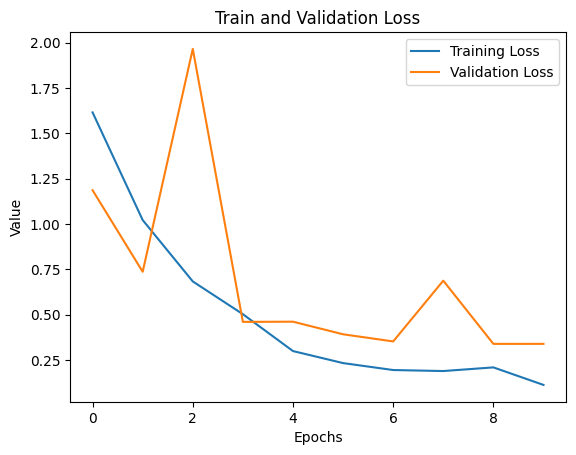

In [7]:
plt.figure()
plt.plot(history['train']['loss'], label='Training Loss')
plt.plot(history['val']['loss'], label='Validation Loss')
plt.title("Train and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

# Plot train and validation accuracy

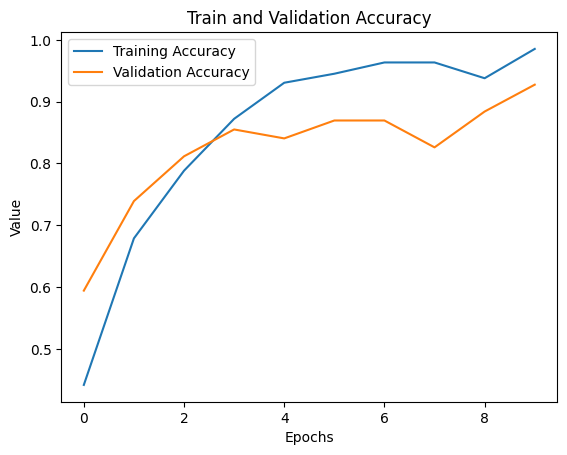

In [8]:
plt.figure()
plt.plot(history['train']['acc'], label='Training Accuracy')
plt.plot(history['val']['acc'], label='Validation Accuracy')
plt.title("Train and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

# Test model

In [9]:
result = model.evaluate(test_dataloader, criterion, device=device)

Evaluation - Loss: 0.5795, Acc: 0.7907, Prec: 0.8223, Rec: 0.8000, F1: 0.7886


# Plot confusion matrix

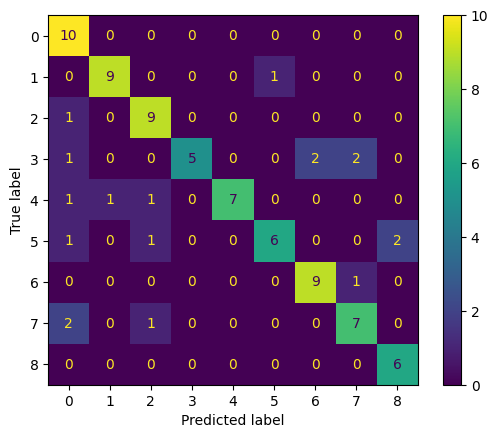

In [10]:
disp = ConfusionMatrixDisplay(confusion_matrix=result['cm'])
disp.plot()
plt.show()